In [1]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
train_dir = "D:/Work/Corrosion_Detection/Data_Split/Train"
train_CORROSION_dir = "D:/Work/Corrosion_Detection/Data_Split/Train/CORROSION"
train_NOCORROSION_dir = "D:/Work/Corrosion_Detection/Data_Split/Train/NOCORROSION"

validation_dir = "D:/Work/Corrosion_Detection/Data_Split/Validation"
validation_CORROSION_dir = "D:/Work/Corrosion_Detection/Data_Split/Validation/CORROSION"
validation_NOCORROSION_dir = "D:/Work/Corrosion_Detection/Data_Split/Validation/NOCORROSION"

test_dir = "D:/Work/Corrosion_Detection/Data_Split/Test"
test_CORROSION_dir = "D:/Work/Corrosion_Detection/Data_Split/Test/CORROSION"
test_NOCORROSION_dir = "D:/Work/Corrosion_Detection/Data_Split/Test/NOCORROSION"

In [3]:
def num_files_in_direcotry(path):
    num = len([file for file in os.listdir(path) if file.endswith('.jpg')])
    return num

In [4]:
train_CORROSION_num = num_files_in_direcotry(train_CORROSION_dir)
train_NOCORROSION_num = num_files_in_direcotry(train_NOCORROSION_dir)
train_SUM_num = train_CORROSION_num + train_NOCORROSION_num

print("[Train] Number of CORROSION Images: ", train_CORROSION_num)
print("[Train] Number of NOCORROSION Images: ", train_NOCORROSION_num)
print("[Train] Number of TOTAL Images: ", train_SUM_num)

[Train] Number of CORROSION Images:  1756
[Train] Number of NOCORROSION Images:  1052
[Train] Number of TOTAL Images:  2808


In [5]:
val_CORROSION_num = num_files_in_direcotry(validation_CORROSION_dir)
val_NOCORROSION_num = num_files_in_direcotry(validation_NOCORROSION_dir)
val_SUM_num = val_CORROSION_num + val_NOCORROSION_num

print("[Validation] Number of CORROSION Images: ", val_CORROSION_num)
print("[Validation] Number of NOCORROSION Images: ", val_NOCORROSION_num)
print("[Validation] Number of TOTAL Images: ", val_SUM_num)

[Validation] Number of CORROSION Images:  502
[Validation] Number of NOCORROSION Images:  301
[Validation] Number of TOTAL Images:  803


In [6]:
test_CORROSION_num = num_files_in_direcotry(test_CORROSION_dir)
test_NOCORROSION_num = num_files_in_direcotry(test_NOCORROSION_dir)
test_SUM_num = test_CORROSION_num + test_NOCORROSION_num

print("[Test] Number of CORROSION Images: ", test_CORROSION_num)
print("[Test] Number of NOCORROSION Images: ", test_NOCORROSION_num)
print("[Test] Number of TOTAL Images: ", test_SUM_num)

[Test] Number of CORROSION Images:  250
[Test] Number of NOCORROSION Images:  150
[Test] Number of TOTAL Images:  400


In [13]:
def create_charts(cnn, cnn_model):
    """
    plot1: train & validatoin loss curves
    plot2: train & validatoin accuracy curves
    Plot3: confusion matrix
    Plot4: train & validation ROC curve and AUC score
    Summary Statistics
    
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation accuracy
    train_auc = cnn_model.history.get('accuracy', cnn_model.history.get('acc'))
    val_auc = cnn_model.history.get('val_accuracy', cnn_model.history.get('val_acc'))
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION Accuracy
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  
    names = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['CORROSION', 'NOCORROSION']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TP, FN, FP, TN = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [8]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (224,224),
                                         batch_size = 32,
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42
                                         )
        generator_lst.append(g)
    
    return generator_lst

In [9]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 2808 images belonging to 2 classes.
Found 803 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


Model 1 ->

In [10]:
 # Design the model
    
def build_model_1():
    cnn = Sequential()

    # Change Input Shape to (224, 224, 3)
    cnn.add(InputLayer(input_shape=(224, 224, 3)))

    # Start with 32 filters and increase gradually
    cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    cnn.add(MaxPooling2D((2, 2)))

    # Flatten for Dense Layers
    cnn.add(Flatten())

    # Fully Connected Layers
    cnn.add(Dense(512, activation='relu'))
    cnn.add(Dropout(0.5))  # Helps prevent overfitting
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.3))

    # Output Layer (Binary Classification)
    cnn.add(Dense(1, activation='sigmoid'))  

    # Compile Model
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return cnn

cnn = build_model_1()
cnn.summary()  # Print model architecture




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)     

In [11]:
# Train the model

cnn_model = cnn.fit_generator(train_generator,
                              epochs = 20,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

C:\Users\RAJANA~1\AppData\Local\Temp/ipykernel_7840/1447062415.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_model = cnn.fit_generator(train_generator,


Epoch 1/20


88/88 [==============================] - 145s 2s/step - loss: 0.2878 - accuracy: 0.9038 - val_loss: 0.1756 - val_accuracy: 0.9465
Epoch 2/20
88/88 [==============================] - 108s 1s/step - loss: 0.1897 - accuracy: 0.9420 - val_loss: 0.2280 - val_accuracy: 0.9465
Epoch 3/20
88/88 [==============================] - 96s 1s/step - loss: 0.1699 - accuracy: 0.9537 - val_loss: 0.2247 - val_accuracy: 0.9365
Epoch 4/20
88/88 [==============================] - 99s 1s/step - loss: 0.1603 - accuracy: 0.9498 - val_loss: 0.1866 - val_accuracy: 0.9440
Epoch 5/20
88/88 [==============================] - 97s 1s/step - loss: 0.1701 - accuracy: 0.9573 - val_loss: 0.2760 - val_accuracy: 0.9440
Epoch 6/20
88/88 [==============================] - 96s 1s/step - loss: 0.1447 - accuracy: 0.9569 - val_loss: 0.1922 - val_accuracy: 0.9477
Epoch 7/20
88/88 [==============================] - 97s 1s/step - loss: 0.1399 - accuracy: 0.9626 - val_loss: 0.2473 - val_accuracy: 0.9315
Epoch 8/20
88/88

C:\Users\RAJANA~1\AppData\Local\Temp/ipykernel_7840/1809269218.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 99.00% | Precision = 98.81% | Recall = 99.60% | Specificity = 98.00% | F1 Score = 99.20%


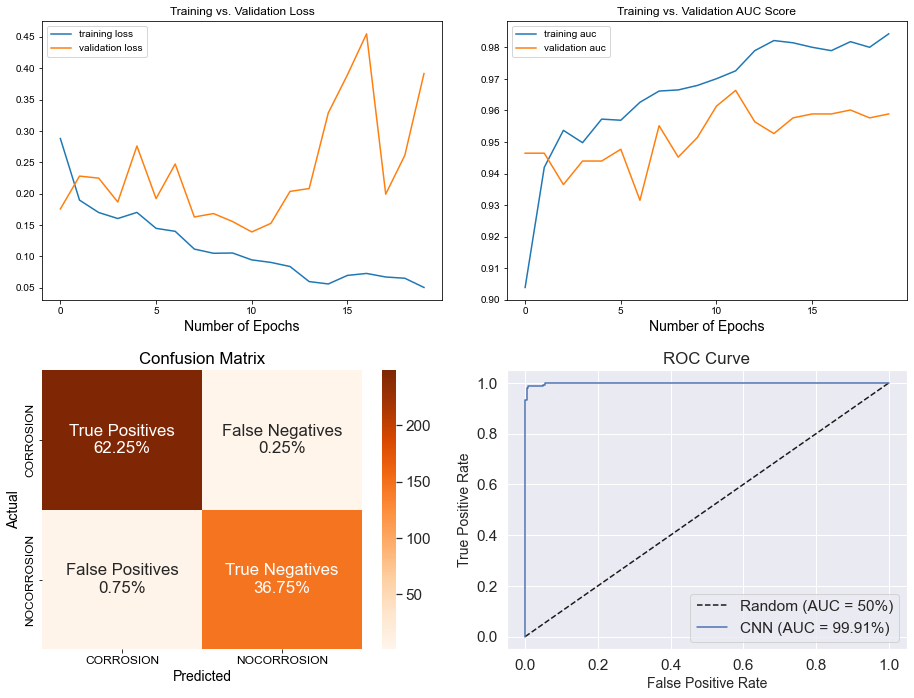

In [14]:
create_charts(cnn,cnn_model)

Model 2 with improvements -->

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 2808 images belonging to 2 classes.
Found 803 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [22]:
# Build Optimized CNN Model
def build_model():
    cnn = Sequential()

    cnn.add(Input(shape=(224, 224, 3)))

    # Block 1
    cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D((2, 2)))

    # Block 2
    cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D((2, 2)))

    # Block 3 (Reduced Complexity)
    cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D((2, 2)))

    # Fully Connected Layers with Increased Dropout
    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.4))  # Increased dropout to prevent overfitting
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.3))  
    cnn.add(Dense(1, activation='sigmoid'))  # Output for binary classification

    # Compile Model with AdamW Optimizer
    cnn.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    return cnn

cnn = build_model()
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                      

In [23]:
# Callbacks: Early Stopping + Learning Rate Scheduling
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the Model
cnn_model = cnn.fit(train_generator,
                    epochs=20,
                    validation_data=val_generator,
                    callbacks=[early_stop, lr_scheduler],
                    verbose=1)

Epoch 1/20
88/88 [==============================] - 98s 1s/step - loss: 3.1986 - accuracy: 0.8333 - val_loss: 1.5769 - val_accuracy: 0.7061 - lr: 0.0010
Epoch 2/20
88/88 [==============================] - 91s 1s/step - loss: 2.0702 - accuracy: 0.8668 - val_loss: 1.0211 - val_accuracy: 0.7758 - lr: 0.0010
Epoch 3/20
88/88 [==============================] - 96s 1s/step - loss: 1.2239 - accuracy: 0.8707 - val_loss: 0.6092 - val_accuracy: 0.7335 - lr: 0.0010
Epoch 4/20
88/88 [==============================] - 91s 1s/step - loss: 0.6620 - accuracy: 0.8793 - val_loss: 0.5480 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 5/20
88/88 [==============================] - 91s 1s/step - loss: 0.5506 - accuracy: 0.8992 - val_loss: 0.4751 - val_accuracy: 0.7970 - lr: 0.0010
Epoch 6/20
88/88 [==============================] - 92s 1s/step - loss: 0.3900 - accuracy: 0.8871 - val_loss: 0.3328 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 7/20
88/88 [==============================] - 97s 1s/step - loss: 0.2732 - a

C:\Users\RAJANA~1\AppData\Local\Temp/ipykernel_7840/1809269218.py:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 94.50% | Precision = 100.00% | Recall = 91.20% | Specificity = 100.00% | F1 Score = 95.40%


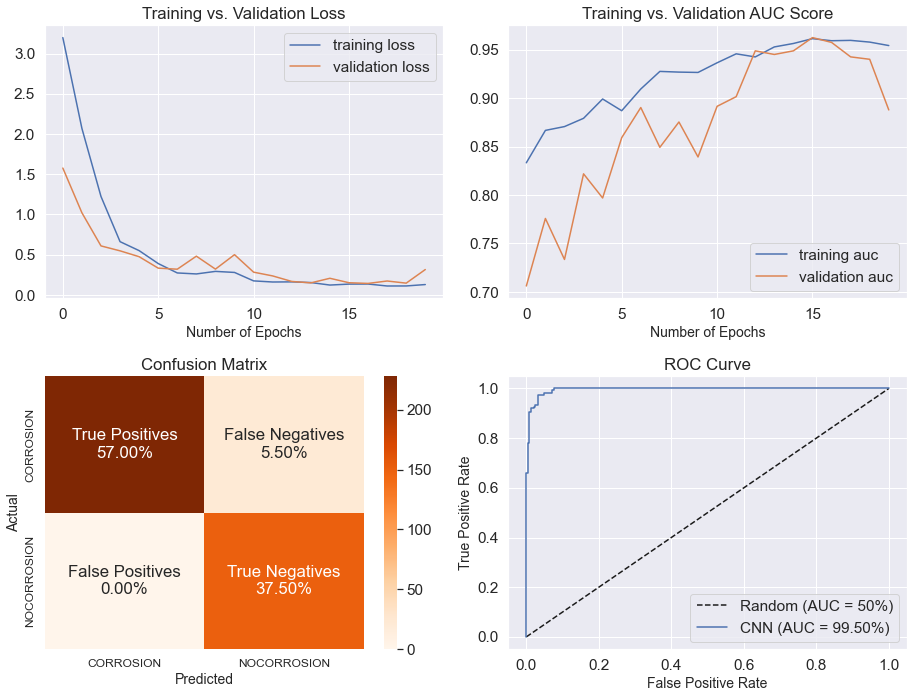

In [24]:
create_charts(cnn,cnn_model)